# Autoencoders

В этом ноутбуке мы будем тренировать автоэнкодеры кодировать лица людей. Для этого возьмем следующий датасет: "Labeled Faces in the Wild" (LFW) (http://vis-www.cs.umass.edu/lfw/). Код для скачивания и загрузки датасета написан за вас в файле get_dataset.py


## Prepare the data

In [0]:
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from get_dataset import fetch_dataset
data, attrs = fetch_dataset()

In [0]:
IMAGE_H = data.shape[1]
IMAGE_W = data.shape[2]
# у нас цветные изображения
N_CHANNELS = 3

TRAIN_SIZE = 10000
VAL_SIZE = data.shape[0] - TRAIN_SIZE


Разбейте выборку картинок на train и val и приведите значения элементов в интервал [0, 1] типа float

In [0]:
data_normalized = (data - data.min())/(data.max() - data.min())

X_train = data_normalized[:TRAIN_SIZE,:]
X_val = data_normalized[TRAIN_SIZE:TRAIN_SIZE + VAL_SIZE, :] 

Напишем вспомогательную функцию, которая будет выводить n_row $\cdot$ n_col первых картинок в массиве images:

In [0]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        try:
            plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
            plt.xticks(())
            plt.yticks(())
        except:
            pass

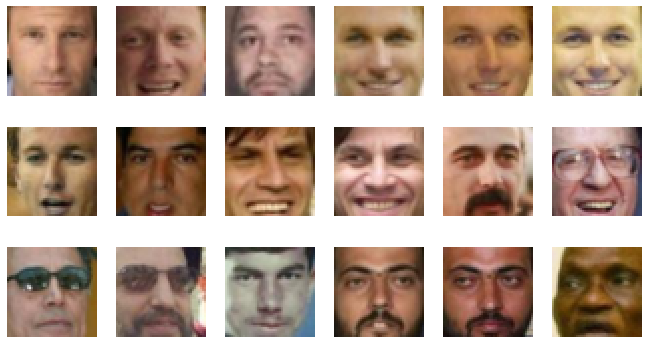

In [7]:
plot_gallery(X_train, IMAGE_H, IMAGE_W)

Осталось привести картинки к тензорам из PyTorch, чтобы можно было потом скармливать их автоэнкодеру: 

In [0]:
X_train = torch.Tensor(X_train)
X_val = torch.Tensor(X_val)

# Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:
<img src="https://i.imgur.com/nVJAtMT.png" alt="Autoencoder">

In [0]:
inp_size=X_train.shape[1]
hid_size=256
dimZ=128

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

# [T] Добрый день/вечер/ночь, дорогой человек, проверяющий проект!

В конце тренировки каждой модели есть ячейки для сохранения и загрузки. Так что обученные модельки в вашем распоряжении :)

Гуд лак!

![Йода](https://res.cloudinary.com/teepublic/image/private/s--tk6rmaSK--/t_Preview/b_rgb:ffffff,c_limit,f_jpg,h_630,q_90,w_630/v1486408455/production/designs/1187739_1.jpg)

In [0]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder_conv_1 = nn.Conv2d(3, 32, kernel_size = 3, stride=2, padding = 0)
        self.encoder_linear_1 = nn.Linear(32*22*22, hid_size)
        self.encoder_linear_2 = nn.Linear(hid_size, dimZ)
        self.decoder_linear_2 = nn.Linear(dimZ, hid_size)
        self.decoder_linear_1 = nn.Linear(hid_size, 32*22*22)
        self.decoder_conv_1 = nn.ConvTranspose2d(in_channels = 32, out_channels = 3, kernel_size = 3, stride=2, padding = 0)
    def encode(self, x):
        x = F.elu(self.encoder_conv_1(x.view(-1, 3, 45, 45)))
        x = x.view(-1, 32*22*22) 
        x = F.elu(self.encoder_linear_1(x))
        latent_code = F.elu(self.encoder_linear_2(x))
        return latent_code
    def decode(self, latent_code):
        x = F.elu(self.decoder_linear_2(latent_code))
        x = F.elu(self.decoder_linear_1(x))
        x = x.view(-1, 32, 22, 22)
        reconstruction = torch.sigmoid(self.decoder_conv_1(x)).view(-1,45,45,3)
        return reconstruction
    def forward(self, x):
        latent_code = self.encode(x)
        reconstruction = self.decode(latent_code)
        return reconstruction, latent_code

In [0]:
criterion = nn.MSELoss()

if torch.cuda.is_available():
    autoencoder = Autoencoder().cuda()
else:
    autoencoder = Autoencoder()
    
learning_rate = 1e-4
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

Подсказка: если x_val -- каринка, а reconstruction -- ее реконструкция автоэнкодером, то красиво вывести эту каритинку и ее реконструкцию можно с помощью функции plot_gallery вот так:

*plot_gallery([x_val, reconstruction], image_h, image_w, n_row=1, n_col=2)* (нет)

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [0]:
batch_size = 100
train_loader = torch.utils.data.DataLoader(X_train, batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(X_val, batch_size, shuffle=False)

In [0]:
def train(model, train_loader, optimizer):
    model.train()
    loss_train_append = 0
    for data in train_loader:
        image_train = data
        if torch.cuda.is_available():
            image_train = image_train.cuda()
        image_train = Variable(image_train)
        image_train_reconstructed, code = model(image_train)
        loss_train = criterion(image_train_reconstructed, image_train)
        loss_train_append+=loss_train.item()
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
    loss_train_append /= len(train_loader)
    return loss_train_append
  
def test(model, test_loader):
    model.eval()
    loss_val_append = 0
    for data in test_loader:
        image_val = data
        if torch.cuda.is_available():
            image_val = image_val.cuda()
        image_val = Variable(image_val)
        image_val_reconstructed, code = model(image_val)
        loss_val = criterion(image_val_reconstructed, image_val)
        loss_val_append+=loss_val.item()
    loss_val_append /= len(test_loader)
    return loss_val_append

*В общем не получается выводить картинки в процессе. Решила сделать так, чтобы после завершения процесса обучения можно было смотреть как развивалась ситуация, потому что смотреть в процессе ни **plot_gallery**, ни **imshow** не позволяют. А еще графики тоже в конце появляются, да. В процессе их выводить не вижу смысла.*

Epoch:1, train loss:0.0293, val loss:0.0196
Epoch:2, train loss:0.0156, val loss:0.0131
Epoch:3, train loss:0.0122, val loss:0.0114
Epoch:4, train loss:0.0110, val loss:0.0104
Epoch:5, train loss:0.0100, val loss:0.0095
Epoch:6, train loss:0.0092, val loss:0.0088
Epoch:7, train loss:0.0086, val loss:0.0082
Epoch:8, train loss:0.0081, val loss:0.0078
Epoch:9, train loss:0.0077, val loss:0.0074
Epoch:10, train loss:0.0074, val loss:0.0071
Epoch:11, train loss:0.0071, val loss:0.0068
Epoch:12, train loss:0.0068, val loss:0.0066
Epoch:13, train loss:0.0065, val loss:0.0063
Epoch:14, train loss:0.0063, val loss:0.0061
Epoch:15, train loss:0.0060, val loss:0.0059
Epoch:16, train loss:0.0058, val loss:0.0057
Epoch:17, train loss:0.0057, val loss:0.0055
Epoch:18, train loss:0.0055, val loss:0.0054
Epoch:19, train loss:0.0054, val loss:0.0053
Epoch:20, train loss:0.0053, val loss:0.0052
Epoch:21, train loss:0.0052, val loss:0.0051
Epoch:22, train loss:0.0050, val loss:0.0050
Epoch:23, train los

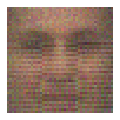

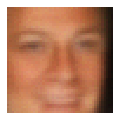

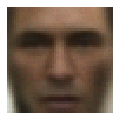

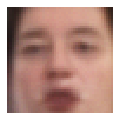

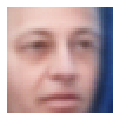

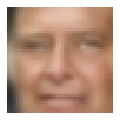

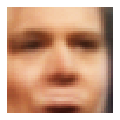

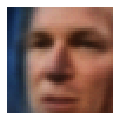

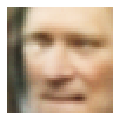

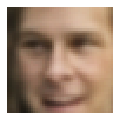

In [0]:
loss_train = []
loss_val = []
epochs = 300
for epoch in range(epochs):
    loss_t = train(autoencoder, train_loader, optimizer)
    loss_train.append(loss_t)
    loss_v = test(autoencoder, test_loader)
    loss_val.append(loss_v)    
    print('Epoch:{}, train loss:{:.4f}, val loss:{:.4f}'.format(epoch+1, loss_train[epoch], loss_val[epoch]))
    if epoch % 30 == 0:
        X = X_val[np.random.choice(VAL_SIZE)]
        if torch.cuda.is_available():
            X_pass = torch.Tensor(X).cuda()
        else:
            X_pass = torch.Tensor(X)
        plot_gallery(autoencoder(X_pass)[0].data.cpu().numpy(), IMAGE_H, IMAGE_W, n_row=1, n_col=1) #СМОТРИТЕ ТЕКСТ НАД ЯЧЕЙКОЙ

In [0]:
def loss_show(loss_train, loss_val):
    plt.plot([i for i in range(len(loss_train))], loss_train, c='r', label='Training loss')
    plt.plot([i for i in range(len(loss_val))], loss_val, c = 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()    

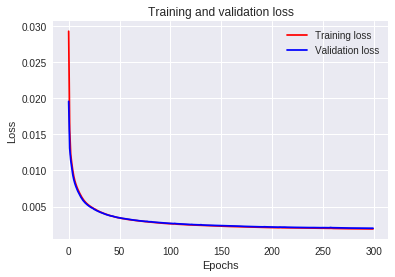

In [0]:
loss_show(loss_train, loss_val)

In [0]:
torch.save(autoencoder.state_dict(), 'Autoencoder.pt')

In [0]:
#обученная
net = Autoencoder()
net.load_state_dict(torch.load('Autoencoder.pt'))
if torch.cuda.is_available():
    net = net.cuda()

#**Denoising

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


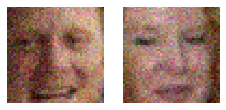

In [0]:
noise_factor = 0.07
X_train_noisy = X_train.numpy() + noise_factor * np.random.normal(size=X_train.shape)
X_val_noisy = X_val.numpy() + noise_factor * np.random.normal(size=X_val.shape)
plot_gallery(torch.Tensor([X_train_noisy[1], X_val_noisy[1]]).view(-1, 45, 45, 3), IMAGE_H, IMAGE_W, n_row=1, n_col=2)

batch_size = 100
train_loader_noisy = torch.utils.data.DataLoader(torch.Tensor(X_train_noisy), batch_size, shuffle=False)
test_loader_noisy = torch.utils.data.DataLoader(torch.Tensor(X_val_noisy), batch_size, shuffle=False)

In [0]:
from copy import deepcopy

class Autoencoder_noise(nn.Module):
    def __init__(self):
        super(Autoencoder_noise, self).__init__()
        self.encoder_conv_1 = nn.Conv2d(3, 8, kernel_size = 3, stride=1, padding = 0)
        self.encoder_conv_2 = nn.Conv2d(8, 16, kernel_size = 3, stride=1, padding = 1)
        self.encoder_linear_1 = nn.Linear(16*43*43, hid_size)
        self.encoder_linear_2 = nn.Linear(hid_size, dimZ)
        self.decoder_linear_2 = nn.Linear(dimZ, hid_size)
        self.decoder_linear_1 = nn.Linear(hid_size, 16*43*43)
        self.decoder_conv_2 = nn.ConvTranspose2d(in_channels = 16, out_channels = 8, kernel_size = 3, stride=1, padding = 1)
        self.decoder_conv_1 = nn.ConvTranspose2d(in_channels = 8, out_channels = 3, kernel_size = 3, stride=1, padding = 0)
    def encode(self, x):
        x = F.elu(self.encoder_conv_1(x.view(-1, 3, 45, 45)))
        x = F.elu(self.encoder_conv_2(x))
        x = x.view(-1, 16*43*43) 
        x = F.elu(self.encoder_linear_1(x))
        latent_code = F.elu(self.encoder_linear_2(x))
        return latent_code
    def decode(self, latent_code):
        x = F.elu(self.decoder_linear_2(latent_code))
        x = F.elu(self.decoder_linear_1(x))
        x = x.view(-1, 16, 43, 43)
        x = F.elu(self.decoder_conv_2(x))
        reconstruction = torch.sigmoid(self.decoder_conv_1(x)).view(-1, 45, 45, 3)
        return reconstruction
    def forward(self, x):
        latent_code = self.encode(x)
        reconstruction = self.decode(latent_code)
        return reconstruction, latent_code

In [0]:
criterion = nn.MSELoss()

if torch.cuda.is_available():
    autoencoder_noise = Autoencoder_noise().cuda()
else:
    autoencoder_noise = Autoencoder_noise()
    
learning_rate = 1e-4
optimizer = optim.Adam(autoencoder_noise.parameters(), lr=learning_rate)

Epoch:1, train loss:0.0106, val loss:0.0105
Epoch:2, train loss:0.0105, val loss:0.0104
Epoch:3, train loss:0.0104, val loss:0.0103
Epoch:4, train loss:0.0102, val loss:0.0102
Epoch:5, train loss:0.0101, val loss:0.0101
Epoch:6, train loss:0.0100, val loss:0.0100
Epoch:7, train loss:0.0099, val loss:0.0099
Epoch:8, train loss:0.0099, val loss:0.0098
Epoch:9, train loss:0.0098, val loss:0.0098
Epoch:10, train loss:0.0097, val loss:0.0097
Epoch:11, train loss:0.0096, val loss:0.0096
Epoch:12, train loss:0.0096, val loss:0.0095
Epoch:13, train loss:0.0095, val loss:0.0095
Epoch:14, train loss:0.0095, val loss:0.0094
Epoch:15, train loss:0.0094, val loss:0.0094
Epoch:16, train loss:0.0093, val loss:0.0093
Epoch:17, train loss:0.0092, val loss:0.0093
Epoch:18, train loss:0.0092, val loss:0.0092
Epoch:19, train loss:0.0091, val loss:0.0092
Epoch:20, train loss:0.0091, val loss:0.0091
Epoch:21, train loss:0.0090, val loss:0.0091
Epoch:22, train loss:0.0090, val loss:0.0090
Epoch:23, train los

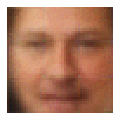

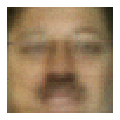

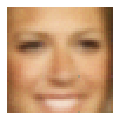

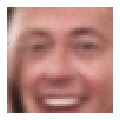

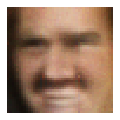

In [0]:
loss_train = []
loss_val = []
epochs = 150
for epoch in range(epochs):
    loss_t = train(autoencoder_noise, train_loader_noisy, optimizer)
    loss_train.append(loss_t)
    loss_v = test(autoencoder_noise, test_loader_noisy)
    loss_val.append(loss_v)    
    print('Epoch:{}, train loss:{:.4f}, val loss:{:.4f}'.format(epoch+1, loss_train[epoch], loss_val[epoch]))
    if epoch % 30 == 0:
        X = X_val_noisy[np.random.choice(VAL_SIZE)]
        if torch.cuda.is_available():
            X_pass = torch.Tensor(X).cuda()
        else:
            X_pass = torch.Tensor(X)
        plot_gallery(autoencoder_noise(X_pass)[0].data.cpu().numpy(), IMAGE_H, IMAGE_W, n_row=1, n_col=1)


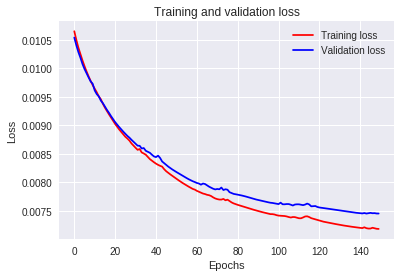

In [0]:
loss_show(loss_train, loss_val)

In [0]:
torch.save(autoencoder_noise.state_dict(), 'Autoencoder_noise.pt')

In [0]:
#обученная
net_2 = Autoencoder_noise()
net_2.load_state_dict(torch.load('Autoencoder_noise.pt'))
if torch.cuda.is_available():
    net_2 = net_2.cuda()

#**Denoising_2

In [0]:
from copy import deepcopy

class Autoencoder_noise_2(nn.Module):
    def __init__(self):
        super(Autoencoder_noise_2, self).__init__()
        self.encoder_conv_1 = nn.Conv2d(3, 16, kernel_size = 3, stride=2, padding = 1)
        self.pool = nn.MaxPool2d(2, stride = 1)
        self.encoder_linear_1 = nn.Linear(16*22*22, hid_size)
        self.encoder_linear_2 = nn.Linear(hid_size, dimZ)
        self.decoder_linear_2 = nn.Linear(dimZ, hid_size)
        self.decoder_linear_1 = nn.Linear(hid_size, 16*22*22)
        self.up = nn.UpsamplingBilinear2d(size = (23, 23))
        self.decoder_conv_1 = nn.ConvTranspose2d(in_channels = 16, out_channels = 3, kernel_size = 3, stride=2, padding = 1)
    def encode(self, x):
        x = self.pool(F.elu(self.encoder_conv_1(x.view(-1, 3, 45, 45))))
        x = x.view(-1, 16*22*22) 
        x = F.elu(self.encoder_linear_1(x))
        latent_code = F.elu(self.encoder_linear_2(x))
        return latent_code
    def decode(self, latent_code):
        x = F.elu(self.decoder_linear_2(latent_code))
        x = F.elu(self.decoder_linear_1(x))
        x = self.up(x.view(-1, 16, 22, 22))
        reconstruction = torch.sigmoid(self.decoder_conv_1(x)).view(-1, 45, 45, 3)
        return reconstruction
    def forward(self, x):
        latent_code = self.encode(x)
        reconstruction = self.decode(latent_code)
        return reconstruction, latent_code

In [0]:
criterion = nn.MSELoss()

if torch.cuda.is_available():
    autoencoder_noise_2 = Autoencoder_noise_2().cuda()
else:
    autoencoder_noise_2 = Autoencoder_noise_2()
    
learning_rate = 1e-4
optimizer = optim.Adam(autoencoder_noise_2.parameters(), lr=learning_rate)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


Epoch:1, train loss:0.0387, val loss:0.0327
Epoch:2, train loss:0.0294, val loss:0.0271
Epoch:3, train loss:0.0258, val loss:0.0243
Epoch:4, train loss:0.0231, val loss:0.0220
Epoch:5, train loss:0.0214, val loss:0.0206
Epoch:6, train loss:0.0201, val loss:0.0194
Epoch:7, train loss:0.0190, val loss:0.0185
Epoch:8, train loss:0.0183, val loss:0.0179
Epoch:9, train loss:0.0177, val loss:0.0174
Epoch:10, train loss:0.0173, val loss:0.0170
Epoch:11, train loss:0.0170, val loss:0.0167
Epoch:12, train loss:0.0167, val loss:0.0164
Epoch:13, train loss:0.0164, val loss:0.0161
Epoch:14, train loss:0.0161, val loss:0.0158
Epoch:15, train loss:0.0158, val loss:0.0155
Epoch:16, train loss:0.0155, val loss:0.0153
Epoch:17, train loss:0.0153, val loss:0.0151
Epoch:18, train loss:0.0151, val loss:0.0149
Epoch:19, train loss:0.0149, val loss:0.0148
Epoch:20, train loss:0.0148, val loss:0.0146
Epoch:21, train loss:0.0146, val loss:0.0144
Epoch:22, train loss:0.0144, val loss:0.0142
Epoch:23, train los

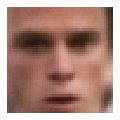

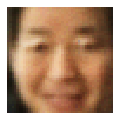

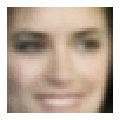

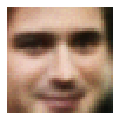

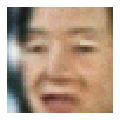

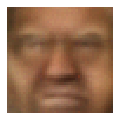

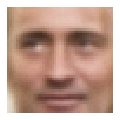

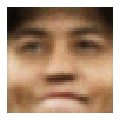

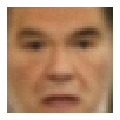

In [0]:
loss_train = []
loss_val = []
epochs = 250
for epoch in range(epochs):
    loss_t = train(autoencoder_noise_2, train_loader_noisy, optimizer)
    loss_train.append(loss_t)
    loss_v = test(autoencoder_noise_2, test_loader_noisy)
    loss_val.append(loss_v)    
    print('Epoch:{}, train loss:{:.4f}, val loss:{:.4f}'.format(epoch+1, loss_train[epoch], loss_val[epoch]))
    if epoch % 30 == 0:
        X = X_val_noisy[np.random.choice(VAL_SIZE)]
        if torch.cuda.is_available():
            X_pass = torch.Tensor(X).cuda()
        else:
            X_pass = torch.Tensor(X)
        plot_gallery(autoencoder_noise(X_pass)[0].data.cpu().numpy(), IMAGE_H, IMAGE_W, n_row=1, n_col=1)

In [0]:
torch.save(autoencoder_noise_2.state_dict(), 'Autoencoder_noise_2.pt')

In [0]:
#обученная
net_2_2 = Autoencoder_noise_2()
net_2_2.load_state_dict(torch.load('Autoencoder_noise_2.pt'))
if torch.cuda.is_available():
    net_2_2 = net_2_2.cuda()

###Проверим работу 3 автоенкодеров на исходном датасете.

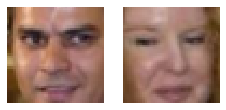

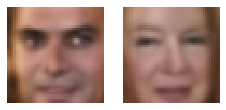

In [0]:
X_val_reconstructed, _ = net(Variable(X_val).cuda())
X_val_reconstructed = X_val_reconstructed.data.cpu().numpy() 
plot_gallery(X_val, IMAGE_H, IMAGE_W, n_row=1, n_col=2)
plot_gallery(X_val_reconstructed, IMAGE_H, IMAGE_W, n_row=1, n_col=2)

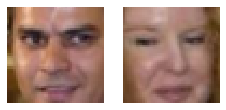

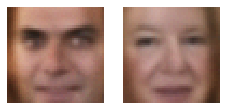

In [0]:
X_val_reconstructed, _ = net_2(Variable(X_val).cuda())
X_val_reconstructed = X_val_reconstructed.data.cpu().numpy() 
plot_gallery(X_val, IMAGE_H, IMAGE_W, n_row=1, n_col=2)
plot_gallery(X_val_reconstructed, IMAGE_H, IMAGE_W, n_row=1, n_col=2)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


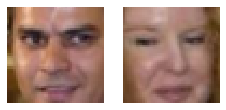

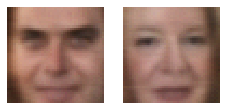

In [0]:
X_val_reconstructed, _ = net_2_2(Variable(X_val).cuda())
X_val_reconstructed = X_val_reconstructed.data.cpu().numpy() 
plot_gallery(X_val, IMAGE_H, IMAGE_W, n_row=1, n_col=2)
plot_gallery(X_val_reconstructed, IMAGE_H, IMAGE_W, n_row=1, n_col=2)

### [T] Первая молодец! И вообще все молодцы! Но юзать будем первую! Ну и для бонуса контраст между нойзом и реконструкцией

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


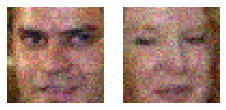

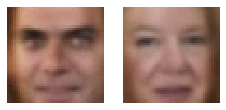

In [0]:
X_val_reconstructed, _ = net_2((Variable(torch.Tensor(X_val_noisy))).cuda())
X_val_reconstructed = X_val_reconstructed.data.cpu().numpy() 
plot_gallery(X_val_noisy, IMAGE_H, IMAGE_W, n_row=1, n_col=2)
plot_gallery(X_val_reconstructed, IMAGE_H, IMAGE_W, n_row=1, n_col=2)

Not bad, right? 

# Sampling

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

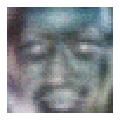

In [0]:
# сгенерируем 25 рандомных векторов размера latent_space
z = np.random.normal(size = (25, dimZ))
z = torch.Tensor(z).cuda()
output = net.decode(z)
output = output.view(25, 45, 45, 3)
plot_gallery(output.data.cpu().numpy(), IMAGE_H, IMAGE_W, n_row=1, n_col=1)

# Congrats!

Time to make fun!

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear">

План такой:

1) Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15 сойдет) людей с улыбками и столько же без

2) Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3) Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

3) А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного чувака и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

6295


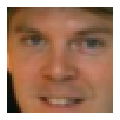

In [0]:
#ищем грустных и счастливых по индексам
import math
ind = math.floor(np.random.random_sample()*TRAIN_SIZE)
print(ind)
plot_gallery(X_train[ind].reshape(1,45,45,3), IMAGE_H, IMAGE_W, n_row=1, n_col=1)

In [0]:
indices_happy = [517, 3218, 7060, 1427, 9014, 7096, 5786, 819, 2283, 640, 5882, 8533, 3328, 7366, 6295]
indices_sad = [1230, 6384, 8695, 7399, 8931, 6493, 5927, 6024, 2322, 3197, 4152, 7587, 3918, 1556, 8730]

In [0]:
def encode(x):
    return net.encode(x)
def decode(x):
    return net.decode(x)
  
codes_happy = torch.Tensor(np.zeros(dimZ).reshape(1, dimZ)).cuda()
codes_sad = torch.Tensor(np.zeros(dimZ).reshape(1, dimZ)).cuda()

for index in indices_happy:
    code_happy = encode(torch.Tensor(X_train[index]).cuda())
    codes_happy = codes_happy.add(code_happy)
code_happy_mean = codes_happy/len(indices_happy)

for index in indices_sad:
    code_sad = encode(torch.Tensor(X_train[index]).cuda())
    codes_sad = codes_sad.add(code_sad)
code_sad_mean = codes_sad/len(indices_sad)

code_smile = code_happy_mean.sub(code_sad_mean)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


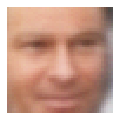

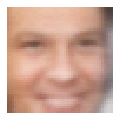

In [0]:
X_sad, code_X_sad = autoencoder_noise(torch.Tensor(X_train[np.random.choice(indices_sad)]).cuda())
code_X_not_sad = code_X_sad.add(code_smile)
X_not_sad = decode(code_X_not_sad)

plot_gallery(X_sad.data.cpu().numpy().reshape(1, 45, 45, 3), IMAGE_H, IMAGE_W, n_row=1, n_col=1)
plot_gallery(X_not_sad.data.cpu().numpy().reshape(1, 45, 45, 3), IMAGE_H, IMAGE_W, n_row=1, n_col=1)

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии)

# BONUS 1. 
### Variational Autoencoder

In [0]:
dimZ=64

https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

In [0]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(45*45*3, 128)
        self.fc21 = nn.Linear(128, dimZ)
        self.fc22 = nn.Linear(128, dimZ)
        self.fc3 = nn.Linear(dimZ, 128)
        self.fc4 = nn.Linear(128, 45*45*3)

    def encode(self, x):
        x = x.view(-1, 45*45*3)
        x = F.relu(self.fc1(x))
        return self.fc21(x), self.fc22(x)
    
    def gaussian_sampler(self, mu, logsigma):
        """
        Функция сэмплирует латентные векторы из нормального распределения с параметрами mu и sigma
        """
        std = logsigma.exp_()
        eps = Variable(std.data.new(std.size()).normal_())
        return eps.mul(std).add_(mu)

    def decode(self, x):
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        reconstruction = torch.sigmoid(x.view(-1, 45, 45, 3))
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        reconstruction = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(reconstruction)
        return reconstruction, mu, logsigma

In [0]:
class VAE_conv(nn.Module):
    def __init__(self):
        super(VAE_conv, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels = 3, out_channels = 4, kernel_size=3, stride = 2, padding = 1)
        self.conv_2 = nn.Conv2d(in_channels = 4, out_channels = 8, kernel_size=3, stride = 2, padding = 1)
        self.fc1 = nn.Linear(8*12*12, 128)
        self.fc21 = nn.Linear(128, dimZ)
        self.fc22 = nn.Linear(128, dimZ)
        self.fc3 = nn.Linear(dimZ, 128)
        self.fc4 = nn.Linear(128, 8*12*12)
        self.conv_3 = nn.ConvTranspose2d(in_channels = 8, out_channels = 4, kernel_size = 3, stride = 2, padding = 1)
        self.conv_4 = nn.ConvTranspose2d(in_channels = 4, out_channels = 3, kernel_size = 3, stride =2, padding = 1)

    def encode(self, x):
        x = F.relu(self.conv_1(x.view(-1, 3, 45, 45)))
        x = F.relu(self.conv_2(x))
        x = x.view(-1, 8*12*12)
        x = F.relu(self.fc1(x))
        return self.fc21(x), self.fc22(x)
    
    def gaussian_sampler(self, mu, logsigma):
        """
        Функция сэмплирует латентные векторы из нормального распределения с параметрами mu и sigma
        """
        std = logsigma.exp_()
        eps = Variable(std.data.new(std.size()).normal_())
        return eps.mul(std).add_(mu)

    def decode(self, x):
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        x = F.relu(self.conv_3(x.view(-1, 8, 12, 12)))
        x = self.conv_4(x)
        reconstruction = torch.sigmoid(x.view(-1,45,45,3))
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x.view(-1, 45*45*3))
        reconstruction = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(reconstruction)
        return reconstruction, mu, logsigma

Определим лосс и его компоненты для VAE:

In [0]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    return -(1/2) * (1 + logsigma - mu**2 - torch.exp(logsigma)**2).sum(dim=-1)

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss()
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return (KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)).mean()

И обучим модель:

In [0]:
if torch.cuda.is_available():
    vae = VAE().cuda()
else:
    vae = VAE()

learning_rate = 1e-4
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

In [0]:
if torch.cuda.is_available():
    vae_conv = VAE_conv().cuda()
else:
    vae_conv = VAE_conv()

learning_rate = 1e-4
optimizer = optim.Adam(vae_conv.parameters(), lr=learning_rate)

In [0]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(X_train, batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(X_val, batch_size, shuffle=False)

In [0]:
def train_vae(model, train_loader, optimizer):
    model.train()
    loss_train_append = 0
    for data in train_loader:
        image_train = data
        if torch.cuda.is_available():
            image_train = image_train.cuda()
        image_train = Variable(image_train)
        image_train_reconstructed, mu, logsigma = model(image_train)
        loss_train = loss_vae(image_train, mu, logsigma, image_train_reconstructed)
        loss_train_append+=loss_train.item()
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
    loss_train_append /= len(train_loader)
    return loss_train_append
  
def test_vae(model, test_loader):
    model.eval()
    loss_val_append = 0
    for data in test_loader:
        image_val = data
        if torch.cuda.is_available():
            image_val = image_val.cuda()
        image_val = Variable(image_val)
        image_val_reconstructed, mu, logsigma = model(image_val)
        loss_val = loss_vae(image_val, mu, logsigma, image_val_reconstructed)
        loss_val_append+=loss_val.item()
    loss_val_append /= len(test_loader)
    return loss_val_append

Epoch:1, train loss:20.5416, val loss:2.1293
Epoch:2, train loss:1.4432, val loss:1.1327
Epoch:3, train loss:0.9754, val loss:0.8986
Epoch:4, train loss:0.8331, val loss:0.8037
Epoch:5, train loss:0.7694, val loss:0.7564
Epoch:6, train loss:0.7355, val loss:0.7291
Epoch:7, train loss:0.7151, val loss:0.7110
Epoch:8, train loss:0.7014, val loss:0.6984
Epoch:9, train loss:0.6913, val loss:0.6889
Epoch:10, train loss:0.6833, val loss:0.6812
Epoch:11, train loss:0.6766, val loss:0.6745
Epoch:12, train loss:0.6709, val loss:0.6690
Epoch:13, train loss:0.6664, val loss:0.6660
Epoch:14, train loss:0.6640, val loss:0.6624
Epoch:15, train loss:0.6605, val loss:0.6595
Epoch:16, train loss:0.6617, val loss:0.6581
Epoch:17, train loss:0.6564, val loss:0.6571
Epoch:18, train loss:0.6554, val loss:0.6539
Epoch:19, train loss:0.6582, val loss:0.6523
Epoch:20, train loss:0.6530, val loss:0.6529
Epoch:21, train loss:0.6519, val loss:0.6499
Epoch:22, train loss:0.6556, val loss:0.6494
Epoch:23, train lo

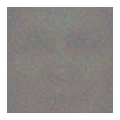

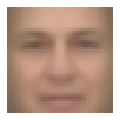

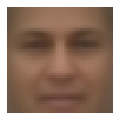

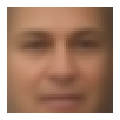

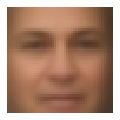

In [89]:
loss_train = []
loss_val = []
epochs = 150
for epoch in range(epochs):
    loss_train.append(train_vae(vae, train_loader, optimizer))
    loss_val.append(test_vae(vae, test_loader))    
    print('Epoch:{}, train loss:{:.4f}, val loss:{:.4f}'.format(epoch+1, loss_train[epoch], loss_val[epoch]))
    if epoch % 30 == 0:
        X = X_val[np.random.choice(VAL_SIZE)]
        if torch.cuda.is_available():
            X_pass = torch.Tensor(X).cuda()
        else:
            X_pass = torch.Tensor(X)
        plot_gallery(vae(X_pass)[0].data.cpu().numpy(), IMAGE_H, IMAGE_W, n_row=1, n_col=1)


Epoch:1, train loss:66.8857, val loss:5.8936
Epoch:2, train loss:2.2009, val loss:0.8614
Epoch:3, train loss:0.7566, val loss:0.7159
Epoch:4, train loss:0.7030, val loss:0.6947
Epoch:5, train loss:0.6885, val loss:0.6837
Epoch:6, train loss:0.6809, val loss:0.6781
Epoch:7, train loss:0.6768, val loss:0.6749
Epoch:8, train loss:0.6744, val loss:0.6729
Epoch:9, train loss:0.6726, val loss:0.6714
Epoch:10, train loss:0.6714, val loss:0.6704
Epoch:11, train loss:0.6705, val loss:0.6696
Epoch:12, train loss:0.6698, val loss:0.6690
Epoch:13, train loss:0.6692, val loss:0.6681
Epoch:14, train loss:0.6686, val loss:0.6677
Epoch:15, train loss:0.6679, val loss:0.6670
Epoch:16, train loss:0.6676, val loss:0.6665
Epoch:17, train loss:0.6671, val loss:0.6670
Epoch:18, train loss:0.6667, val loss:0.6662
Epoch:19, train loss:0.6664, val loss:0.6651
Epoch:20, train loss:0.6659, val loss:0.6646
Epoch:21, train loss:0.6654, val loss:0.6640
Epoch:22, train loss:0.6648, val loss:0.6645
Epoch:23, train lo

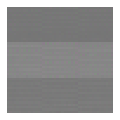

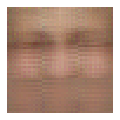

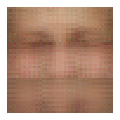

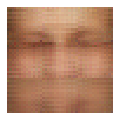

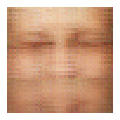

In [83]:
loss_train = []
loss_val = []
epochs = 150
for epoch in range(epochs):
    loss_train.append(train_vae(vae_conv, train_loader, optimizer))
    loss_val.append(test_vae(vae_conv, test_loader))    
    print('Epoch:{}, train loss:{:.4f}, val loss:{:.4f}'.format(epoch+1, loss_train[epoch], loss_val[epoch]))
    if epoch % 30 == 0:
        X = X_val[np.random.choice(VAL_SIZE)]
        if torch.cuda.is_available():
            X_pass = torch.Tensor(X).cuda()
        else:
            X_pass = torch.Tensor(X)
        plot_gallery(vae_conv(X_pass)[0].data.cpu().numpy(), IMAGE_H, IMAGE_W, n_row=1, n_col=1)

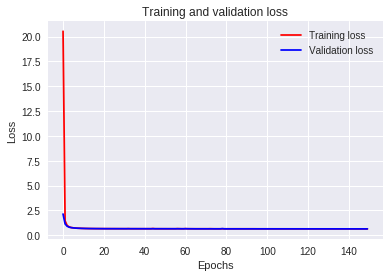

In [90]:
loss_show(loss_train, loss_val)

In [0]:
torch.save(vae.state_dict(), 'VAE.pt')

In [0]:
torch.save(vae_conv.state_dict(), 'VAE_CONV.pt')

In [0]:
#обученный вае без сверток
v_ae = VAE()
v_ae.load_state_dict(torch.load('VAE.pt'))
if torch.cuda.is_available():
    v_ae = v_ae.cuda()

In [0]:
#обученный вае со свертками
v_ae_conv = VAE_conv()
v_ae_conv.load_state_dict(torch.load('VAE_CONV.pt'))
if torch.cuda.is_available():
    v_ae_conv = v_ae_conv.cuda()

## [T] Хотя лосс 0.6, учитывая, что мы привели все значения к интервалу [0;1], просто неприличен, но у модели это магическое число. Лезть ниже не хочет. Как только ни крутила гиперпараметры, как только ни крутила архитектуру сети, ну не хочет лезть и все тут. Единственный вариант - возможно, проблема появилась при объявлении лосса (который я кстати подправила, потому что до исправления лосс был около 18). Но там вроде все верно.

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

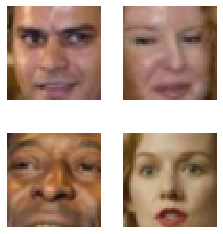

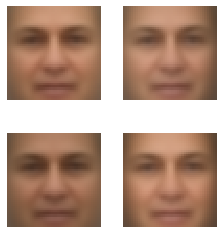

In [95]:
X_val_reconstructed, _, __ = v_ae(Variable(torch.Tensor(X_val)).cuda())
X_val_reconstructed = X_val_reconstructed.data.cpu().numpy() 
plot_gallery(X_val, IMAGE_H, IMAGE_W, n_row=2, n_col=2)
plot_gallery(X_val_reconstructed, IMAGE_H, IMAGE_W, n_row=2, n_col=2)

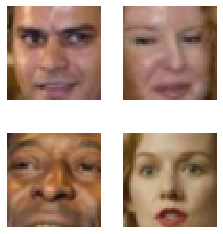

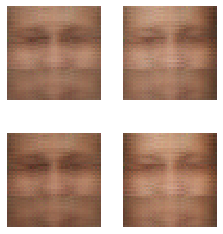

In [97]:
X_val_reconstructed, _, __ = v_ae_conv(Variable(torch.Tensor(X_val)).cuda())
X_val_reconstructed = X_val_reconstructed.data.cpu().numpy() 
plot_gallery(X_val, IMAGE_H, IMAGE_W, n_row=2, n_col=2)
plot_gallery(X_val_reconstructed, IMAGE_H, IMAGE_W, n_row=2, n_col=2)

And finally sample from VAE.

# Sampling

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие лица получатся:

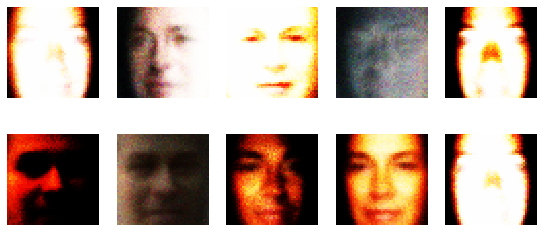

In [98]:
z = np.array([np.random.normal(0, 1, dimZ) for i in range(10)])
output = v_ae.decode(torch.Tensor(z).cuda())
plot_gallery(output.data.cpu().numpy(), IMAGE_H, IMAGE_W, n_row=2, n_col=5)

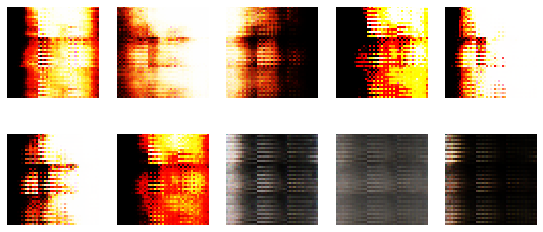

In [100]:
z = np.array([np.random.normal(0, 1, dimZ) for i in range(10)])
output = v_ae_conv.decode(torch.Tensor(z).cuda())
plot_gallery(output.data.cpu().numpy(), IMAGE_H, IMAGE_W, n_row=2, n_col=5)

# Congrats v2.0!

Как вы уже догадались, здесь тоже можно попробовать пририсовывать разные атрибуты людям. Можно, например, так же пририсовать улыбки и сравнить с тем, как это получалось у обычного автоэнкодера

In [0]:
<как вы уже догадались, тут Ваш код>